In [2]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 

import numpy

import save_load_file as slf # https://github.com/ricardodeazambuja/Python-UTILS

from scipy import stats

In [3]:
# Loads the modules and starts the object to be used with the parallel processing iPython stuff...

# Remember to start the clusters:
# https://ipyparallel.readthedocs.org/en/latest/process.html

from ipyparallel import Client

cli = Client()

lbview = cli.load_balanced_view()
# dview = cli[:]

In [4]:
sim_set = "experiment_0001" # basically is the name of the folder where the data is read/saved
base_dir = "simulation_data_00003"

In [5]:
trajectory_number = 0
perfect_shape = slf.load_from_file(base_dir+"/"+sim_set+"/square.pickle")

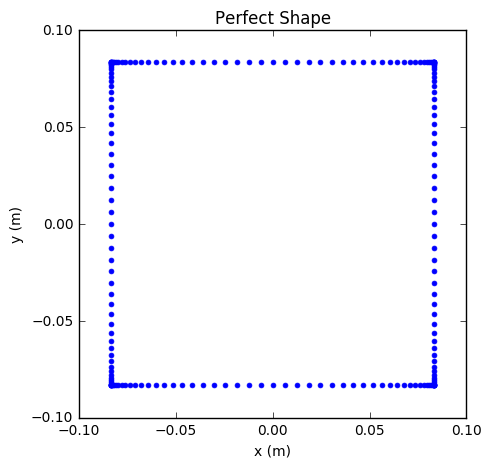

In [6]:
plt.figure(figsize =(5,5))
plt.plot(perfect_shape[::5,0],perfect_shape[::5,1],'.',markersize=7)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Perfect Shape") # Actually the shape generated by the robot is not a perfect shape,
                           # but I think it's better to compare to the perfect square to make it clearer.
plt.show()

In [ ]:
#
# Reads the results from the forward kinematics and calculates the dwt cost
#
@lbview.parallel(block=True)
def calculate_dwt_cost(args):
    import numpy
    # import sys
    
    ((sim_set,base_dir,cwd),perfect_shape,extra_name,total_trials) = args
    
    # sys.path.append(cwd)
    
    import dtw_python # Needs https://github.com/ricardodeazambuja/DTW
    
    xyz_pos = []
    for trial_number in range(total_trials):
        filename = cwd+"/"+base_dir+"/"+sim_set+"/baxter_xyz_joint_angles_mean_parallel_ALL_"+str(trial_number)+extra_name+"_VREP.npy"
        xyz_pos.append(numpy.load(filename))

    xyz_pos = numpy.array(xyz_pos)

    # Translates to match the original initial value (as the simulations always start at that value)
    xyz_pos[:,:,0]+=-xyz_pos[0,0,0]+perfect_shape[0,0]
    xyz_pos[:,:,1]+=-xyz_pos[0,0,1]+perfect_shape[0,1]
    xyz_pos[:,:,2]+=-xyz_pos[0,0,2]

    
    trials_cost = []
    for trial_n in range(total_trials):
        original_drawing = numpy.copy(perfect_shape)
        testing_drawing = numpy.copy(xyz_pos[trial_n,:,0:2])

        dist_matrix = dtw_python.distances_matrix(original_drawing,testing_drawing)

        accumulated_cost = dtw_python.accumulated_cost_matrix(original_drawing,testing_drawing,dist_matrix)

        _, cost = dtw_python.path_cost_calculation(original_drawing,testing_drawing, dist_matrix, accumulated_cost)
        trials_cost.append(cost)

    filename = cwd+"/"+base_dir+"/"+sim_set+"/baxter_xyz_dtw_"+extra_name+".npy"
    numpy.save(filename,trials_cost)

        
    return 0

In [7]:
liqseeds = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")
number_of_liquids = len(liqseeds)
for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [8504 6373 6528 9820 4728 5408]
Liquid 1: [6878 1704 9127 4863 8948 3511]
Liquid 2: [ 214 9852 3943 8654 8283 5606]
Liquid 3: [4730  341 4093 7541  811  467]
Liquid 4: [3202  913 4191 4309 9239 8001]


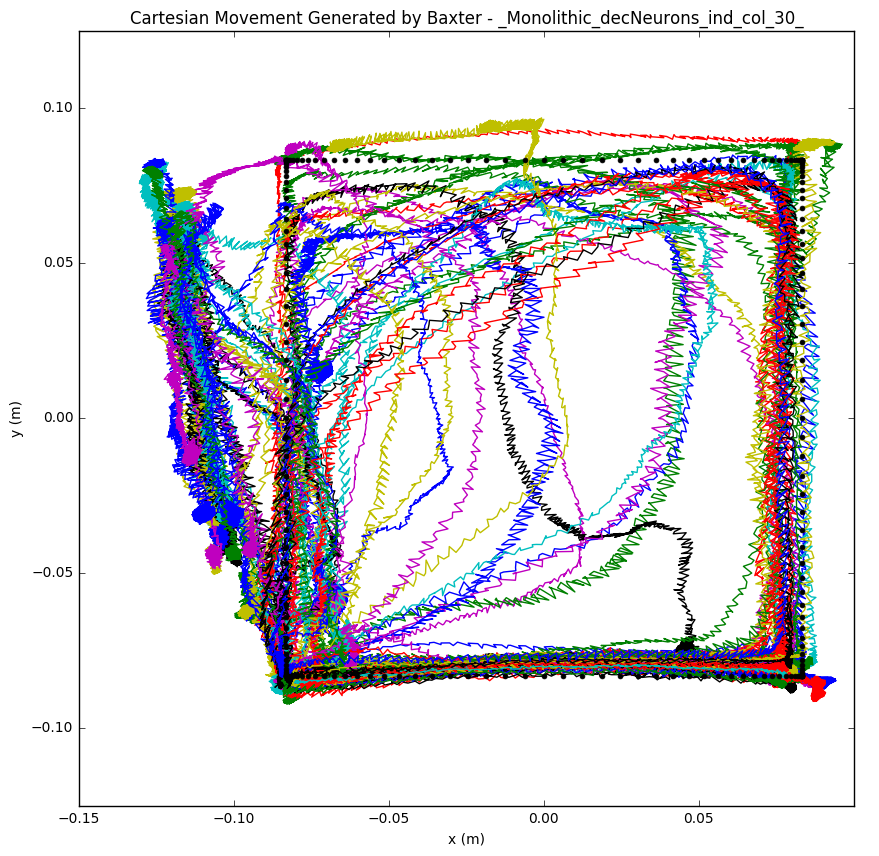

In [11]:
# it's for each column!!!
# percentage_of_decimated_connections = 0.075 # [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
# extra_name = "_Monolithic_decIntConn_"+str(percentage_of_decimated_connections)+"_"
# extra_name = "_Modular_decIntConn_"+str(percentage_of_decimated_connections)+"_"

# number_of_decimated_columns = 4 # [0, 1, 2, 3, 4]
# extra_name = "_Monolithic_decColumns_"+str(number_of_decimated_columns)+"_"
# extra_name = "_Modular_decColumns_"+str(number_of_decimated_columns)+"_"

# it's for each column!!!
# decimated_neurons = 60 # [ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60]
# extra_name = "_Monolithic_decNeurons_" + str(decimated_neurons) + "_"
# extra_name = "_Modular_decNeurons_" + str(decimated_neurons) + "_"

# the decimated neurons are located in only one column (a randomly chosen one)
decimated_neurons = 30 #[  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300]
extra_name = "_Monolithic_decNeurons_ind_col_" + str(decimated_neurons) + "_"
# extra_name = "_Modular_decNeurons_ind_col_" + str(decimated_neurons) + "_"

number_of_trials = 100

# simulation_type = "parallel"

# lsm_i = "ALL"

plt.figure(figsize =(10,10))


for trial_number in range(number_of_trials):

    filename = "./"+base_dir+"/"+sim_set+"/baxter_xyz_joint_angles_mean_parallel_ALL_"+str(trial_number)+extra_name+"_VREP.npy"
    xyz_pos = numpy.load(filename)

    plt.plot(xyz_pos[:,0]-xyz_pos[0,0]+perfect_shape[0,0],
             xyz_pos[:,1]-xyz_pos[0,1]+perfect_shape[0,1])

plt.plot(perfect_shape[::5,0],perfect_shape[::5,1],'k.',markersize=7)

plt.xlabel("x (m)")
plt.ylabel("y (m)")
# plt.xlim([-0.05,0.2])
# plt.ylim([-0.05,0.2])
plt.title("Cartesian Movement Generated by Baxter - "+extra_name)

plt.axes().set_aspect('equal', 'datalim')

plt.show()


In [15]:
# %%time

# #
# # CALCULATES THE DTW COST
# #

# # it's for each column!!!
# # values = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0] # percentage_of_decimated_connections
# # extra_name = "_Monolithic_decIntConn_"
# # extra_name = "_Modular_decIntConn_"

# # values = [0, 1, 2, 3, 4] # number_of_decimated_columns
# # extra_name = "_Monolithic_decColumns_"
# # extra_name = "_Modular_decColumns_"

# # it's for each column!!!
# # values = [ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60] # decimated_neurons
# # extra_name = "_Monolithic_decNeurons_"
# # extra_name = "_Modular_decNeurons_"

# # the decimated neurons are located in only one column (a randomly chosen one)
# # values = [  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300]
# # extra_name = "_Monolithic_decNeurons_ind_col_"
# # extra_name = "_Modular_decNeurons_ind_col_"

    
# number_of_trials = 100

# cwd = ""
# _base_dir = "Users/rdeazambuja/Documents/rdeazambuja_data/GoogleDrive/PhD_Experiments_Data/simulation_data_00003"

# args = []
# for vi in values:
#     _extra_name = extra_name+str(vi)+"_"
#     args.append(((sim_set,_base_dir,cwd),perfect_shape,_extra_name,number_of_trials))

# calculate_dwt_cost.map(args)

CPU times: user 36.6 ms, sys: 10.2 ms, total: 46.7 ms
Wall time: 4.21 s


# Reads the calculated dwt costs

In [20]:
# it's for each column!!!
# values = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0] # percentage_of_decimated_connections
# extra_name = "decIntConn"
# x_label = "Percentage of Decimated Connections"
# x_values = [str(i*100)+"%" for i in values]

# values = [1, 2, 3, 4] # number_of_decimated_columns
# extra_name = "decColumns"
# x_label = "Number of Decimated Columns"
# x_values = [1, 2, 3, 4]


# it's for each column!!!
# values = [ 6, 12, 18, 24, 30, 36, 42, 48, 54, 60] # decimated_neurons
# extra_name = "decNeurons"
# x_label = "Number of Decimated Neurons per Column"
# x_values = [ 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# the decimated neurons are located in only one column (a randomly chosen one)
values = [30,  60,  90, 120, 150, 180, 210, 240, 270, 300]
extra_name = "decNeurons_ind_col"
x_label = "Number of Decimated Neurons per single Column"
x_values = [30,  60,  90, 120, 150, 180, 210, 240, 270, 300]



mod_trials_cost_mean = []
mod_trials_cost_std = []
mod_trials_best = []
mod_trials_worst = []
mod_trials_raw = []

mon_trials_cost_mean = []
mon_trials_cost_std = []
mon_trials_best = []
mon_trials_worst = []
mon_trials_raw = []
for vi in values:
    _extra_name = "_Monolithic_"+extra_name+"_"+str(vi)+"_"
    filename = base_dir+"/"+sim_set+"/baxter_xyz_dtw_"+_extra_name+".npy"
    dwt_costs = numpy.load(filename)
    mon_trials_raw.append(dwt_costs)
    mon_trials_cost_mean.append(dwt_costs.mean())
    mon_trials_best.append(dwt_costs.min())
    mon_trials_worst.append(dwt_costs.max())
    mon_trials_cost_std.append(dwt_costs.std())
    
    _extra_name = "_Modular_"+extra_name+"_"+str(vi)+"_"
    filename = base_dir+"/"+sim_set+"/baxter_xyz_dtw_"+_extra_name+".npy"
    dwt_costs = numpy.load(filename)
    mod_trials_raw.append(dwt_costs)
    mod_trials_cost_mean.append(dwt_costs.mean())
    mod_trials_best.append(dwt_costs.min())
    mod_trials_worst.append(dwt_costs.max())
    mod_trials_cost_std.append(dwt_costs.std())
    
mod_trials_cost_mean = numpy.array(mod_trials_cost_mean)
mod_trials_cost_std = numpy.array(mod_trials_cost_std)
mod_trials_best = numpy.array(mod_trials_best)
mod_trials_worst = numpy.array(mod_trials_worst)
mod_trials_raw = numpy.array(mod_trials_raw)

mon_trials_cost_mean = numpy.array(mon_trials_cost_mean)
mon_trials_cost_std = numpy.array(mon_trials_cost_std)
mon_trials_best = numpy.array(mon_trials_best)
mon_trials_worst = numpy.array(mon_trials_worst)
mon_trials_raw = numpy.array(mon_trials_raw)

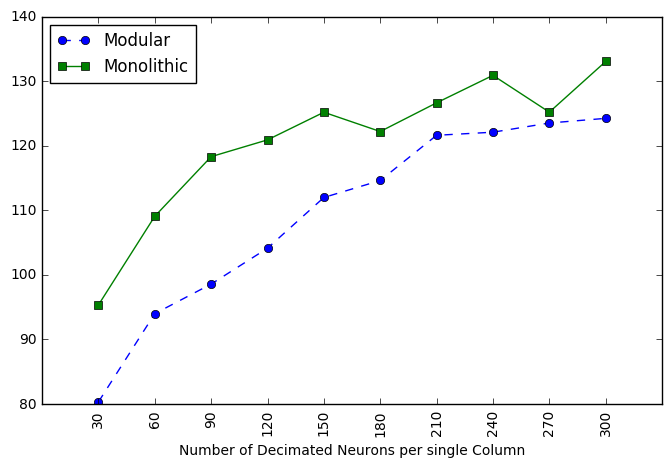

In [21]:
plt.figure(figsize =(8,5))
plt.plot(mod_trials_cost_mean,'o--', label="Modular")
plt.plot(mon_trials_cost_mean,'s-', label="Monolithic")
plt.xticks(range(len(values)),x_values,rotation=90)
plt.xlabel(x_label)
plt.xlim(-1,len(values))
plt.legend(loc=0)
plt.show()

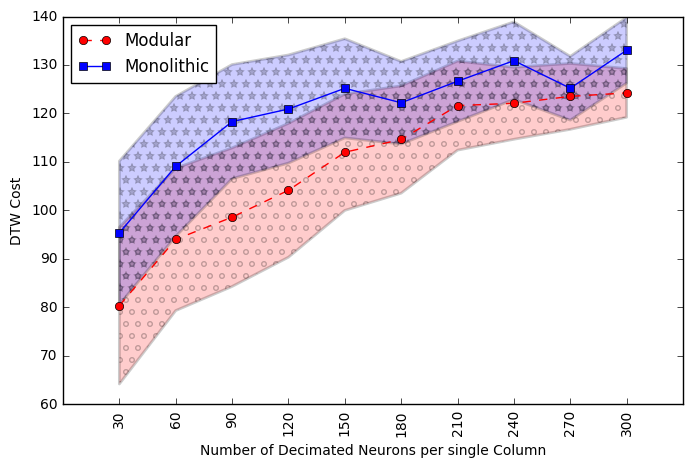

In [22]:
plt.figure(figsize =(8,5))
ax = plt.gca()
ax.fill_between(numpy.arange(mod_trials_cost_mean.shape[0]), 
                mod_trials_cost_mean-mod_trials_cost_std/numpy.sqrt(mod_trials_cost_mean.shape[0]), 
                mod_trials_cost_mean+mod_trials_cost_std/numpy.sqrt(mod_trials_cost_mean.shape[0]), facecolor='red', alpha=0.2, linewidth=2, hatch='o')
plt.plot(mod_trials_cost_mean,'ro--', label="Modular")

ax.fill_between(numpy.arange(mon_trials_cost_mean.shape[0]), 
                mon_trials_cost_mean-mon_trials_cost_std/numpy.sqrt(mon_trials_cost_mean.shape[0]), 
                mon_trials_cost_mean+mon_trials_cost_std/numpy.sqrt(mon_trials_cost_mean.shape[0]), facecolor='blue', alpha=0.2, linewidth=2, hatch='*')
plt.plot(mon_trials_cost_mean,'bs-', label="Monolithic")
plt.xticks(range(len(values)),x_values,rotation=90)
plt.xlabel(x_label)
plt.xlim(-1,len(values))
plt.ylabel("DTW Cost")
plt.legend(loc=0)
plt.show()

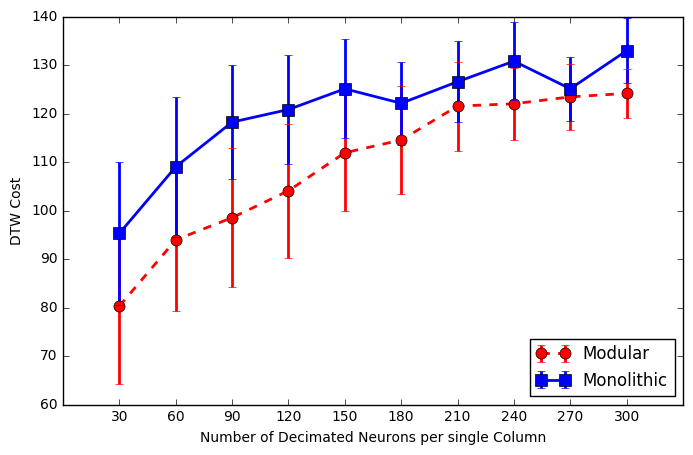

In [23]:
plt.figure(figsize =(8,5))

plt.errorbar(numpy.arange(mod_trials_cost_mean.shape[0]), 
                mod_trials_cost_mean, 
                mod_trials_cost_std/numpy.sqrt(mod_trials_cost_mean.shape[0]), 
                marker='o', linewidth=2, linestyle='--', markersize=8, color='red', label="Modular")

plt.errorbar(numpy.arange(mon_trials_cost_mean.shape[0]), 
                mon_trials_cost_mean, 
                mon_trials_cost_std/numpy.sqrt(mon_trials_cost_mean.shape[0]), 
                marker='s', linewidth=2, linestyle='-', markersize=8, color='blue', label="Monolithic")

plt.xticks(range(len(values)),x_values)
plt.xlabel(x_label)
plt.xlim(-1,len(values))
plt.ylabel("DTW Cost")
plt.legend(loc=0)
plt.savefig("DTWCost_"+extra_name+'.pdf', bbox_inches='tight',pad_inches=1)
plt.show()



In [21]:
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
# http://blog.minitab.com/blog/statistics-and-quality-data-analysis/what-are-t-values-and-p-values-in-statistics
# http://blog.minitab.com/blog/statistics-and-quality-data-analysis/what-is-a-t-test-and-why-is-it-like-telling-a-kid-to-clean-up-that-mess-in-the-kitchen

# stats.ttest_ind(P1,P2, equal_var=False) performs this: https://en.wikipedia.org/wiki/Welch%27s_t_test
results = [stats.ttest_ind(Pmon,Pmod, equal_var=False) for Pmon,Pmod in zip(mon_trials_raw,mod_trials_raw)]

print "Welch’s t-test - " 
for xv,pi in zip(x_values,results):
    print xv,pi[0],pi[1]

Welch’s t-test - 
30 2.15441217534 0.0324252255594
60 2.3022959059 0.0223585017217
90 3.3501520559 0.000973301031869
120 2.97117844123 0.00335078134119
150 2.63113231739 0.00919722993343
180 1.70739838185 0.0894188029611
210 1.27651491765 0.203284051204
240 2.5348546192 0.0120269794904
270 0.558115121917 0.577397013277
300 3.28909275391 0.00120565800268
